# 🎯 Segmentação de **Store** com K-Means

Notebook para segmentar os SKUs, utilizando as variáveis **`square`**, **`type`**, **`Markdown`** e **`Rácio de Labels`**


## 📦 1. Importação das Bibliotecas

Primeiro, vamos importar todas as bibliotecas que precisaremos:

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Configurações de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Ignorar avisos para deixar o notebook mais limpo
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 📊 2. Carregamento e Exploração Inicial dos Dados

Vamos carregar nosso dataset e dar uma primeira olhada nos dados:

In [2]:
# Importar o dataset

csv_path = '/content/draft_normalized_with_store.csv'

df = pd.read_csv(csv_path)
print("🔢 Linhas x Colunas:", df.shape)
display(df.head())

🔢 Linhas x Colunas: (150054, 60)


,idstore,sku,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,sold,selling_square_ft,district,...,d_Marca 5,d_Marca 6,d_Marca 7,d_Marca 8,d_Marca 9,type_encoded,labelling_dow_sin,labelling_dow_cos,expiring_dow_sin,expiring_dow_cos
0,1,1,4.22,260.0,0.16,0.3376,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
1,1,1,3.96,260.0,0.16,0.3168,0.005025,0,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.974928,-0.222521
2,1,1,4.74,260.0,0.16,0.3792,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
3,1,1,4.20,260.0,0.16,0.3360,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
4,1,1,4.62,260.0,0.16,0.3696,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490


## 🧾 3. Criação de dataset para **STORE ID**

In [3]:
# Agregar variáveis

agg_store = (
    df.groupby('idstore', as_index=False)
      .agg(
          type_encoded=('type_encoded','first'),
          selling_square_ft=('selling_square_ft','first'),
          total_labels=('sku','count'),
          total_labels_sold=('sold','sum'),
          district=('district','first')
      )
)

# Derivadas de negócio
agg_store['total_labels'] = agg_store['total_labels'].replace(0, pd.NA)
agg_store['selling_square_ft'] = agg_store['selling_square_ft'].replace(0, pd.NA)
agg_store['markdown_rate'] = (agg_store['total_labels_sold'] / agg_store['total_labels']).fillna(0.0)
agg_store['labels_per_m2'] = (agg_store['total_labels'] / agg_store['selling_square_ft']).fillna(0.0)


print("🔢 Linhas x Colunas (agg_store):", agg_store.shape)
display(agg_store.head(5))


🔢 Linhas x Colunas (agg_store): (332, 8)


,idstore,type_encoded,selling_square_ft,total_labels,total_labels_sold,district,markdown_rate,labels_per_m2
0,1,3,4762.0,481,345,Évora,0.717256,0.101008
1,2,3,12358.0,717,448,Bragança,0.624826,0.058019
2,3,3,16159.0,350,160,Lisboa,0.457143,0.021660
3,4,3,17903.0,462,191,Porto,0.413420,0.025806
4,5,3,16179.0,1192,699,Coimbra,0.586409,0.073676


In [4]:
#Verificar Nulls

print(agg_store.isna().sum())

idstore              0
type_encoded         0
selling_square_ft    0
total_labels         0
total_labels_sold    0
district             0
markdown_rate        0
labels_per_m2        0
dtype: int64


## Outliers

In [5]:
# Parâmetros
q_low = 0.01          # percentil inferior para área
min_area_ft2 = 150.0  # piso mínimo absoluto coerente

# Limiar final para áreas anormalmente baixas
low_area_threshold = max(
    float(agg_store['selling_square_ft'].quantile(q_low)),
    float(min_area_ft2)
)

df_store_flagged = agg_store.copy()
df_store_flagged['flag_low_area'] = (df_store_flagged['selling_square_ft'] < low_area_threshold).astype(int)

# Flags diagnósticas de extremos superiores (não removemos por defeito)
for col in ['markdown_rate','labels_per_m2']:
    lim_sup = df_store_flagged[col].quantile(0.999)
    df_store_flagged[f'flag_hi_{col}'] = (df_store_flagged[col] > lim_sup).astype(int)

print(f"📏 Limiar área baixa (ft²): {low_area_threshold:.2f}")
print("🔍 Lojas com área baixa:", int(df_store_flagged['flag_low_area'].sum()))

# Versão limpa usada no clustering
df_store_clean = df_store_flagged.query('flag_low_area == 0').copy()
print("📉 Dimensão após remoção de outliers (clean):", df_store_clean.shape)

📏 Limiar área baixa (ft²): 150.00
🔍 Lojas com área baixa: 9
📉 Dimensão após remoção de outliers (clean): (323, 11)


## 🔗 4. Seleção de Features

Selecionar as colunas que queremos clusterizar

In [6]:
# Criar Dummies de distrito
# It seems df_store_clean was not defined, using agg_store instead.
# Also, incorporating district dummy columns into agg_store.
agg_store['district'] = agg_store['district'].fillna('Unknown')
agg_store = pd.get_dummies(agg_store, columns=['district'], prefix='dist', drop_first=False)

core_features = ['type_encoded', 'selling_square_ft', 'markdown_rate', 'labels_per_m2']
dist_features = [c for c in agg_store.columns if c.startswith('dist_')]

numeric_features = core_features
all_features = numeric_features + dist_features

X = agg_store[all_features].copy()

# Escalar só números; manter dummies 0/1
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', dist_features)
    ],
    remainder='drop'
)
X_scaled = ct.fit_transform(X)

print("✅ Features preparadas:",
      f"num={len(numeric_features)} | dummies distrito={len(dist_features)} | total={len(all_features)}")

✅ Features preparadas: num=4 | dummies distrito=18 | total=22


## 🎯 5. Escolha do número de clusters (K)
Usamos **método do cotovelo** (inércia) e **silhouette**; por defeito escolhemos o K com *maior silhouette* entre 2 e 10.

Silhouette por K: {2: np.float64(0.2857), 3: np.float64(0.2929), 4: np.float64(0.2592), 5: np.float64(0.265), 6: np.float64(0.224), 7: np.float64(0.1915), 8: np.float64(0.1955), 9: np.float64(0.1845), 10: np.float64(0.1552)}
🎯 K escolhido (maior silhouette): 3


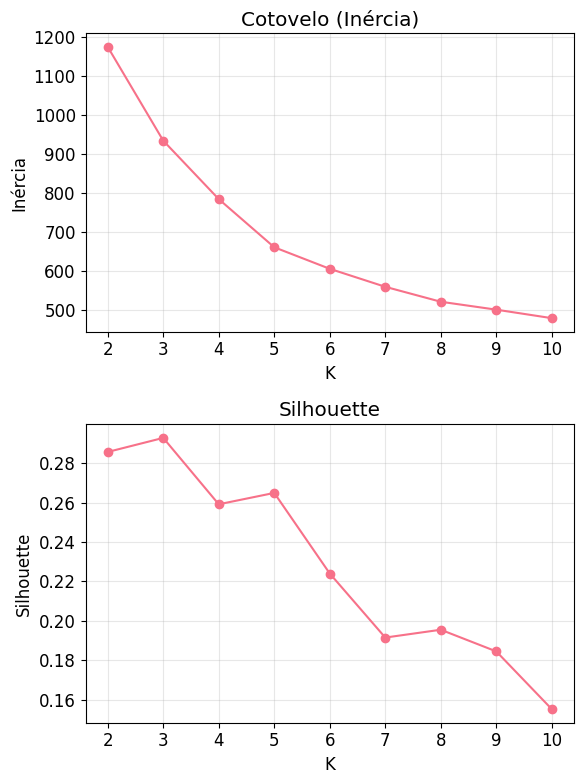

In [7]:
# Inércia (cotovelo)

Ks = range(2, 11)
inertias, silhouettes = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

k_best = int(Ks[np.argmax(silhouettes)])  # sem hardcode
print("Silhouette por K:", dict(zip(Ks, np.round(silhouettes, 4))))
print(f"🎯 K escolhido (maior silhouette): {k_best}")


# Plots
plt.figure(figsize=(6,8))
plt.subplot(2,1,1); plt.plot(list(Ks), inertias, marker='o'); plt.title('Cotovelo (Inércia)')
plt.xlabel('K'); plt.ylabel('Inércia'); plt.grid(True, alpha=0.3)
plt.subplot(2,1,2); plt.plot(list(Ks), silhouettes, marker='o'); plt.title('Silhouette')
plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


## 🏋🏼 6. Treino do K-Means e geração dos rótulos

In [8]:
# Definir o K para os próximos passos
k_best = 4


kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)

df_store_clustered = agg_store.copy()
df_store_clustered['Cluster_KMeans'] = labels


# Centros na escala original
num_scaler = ct.named_transformers_['num']
centers_num = num_scaler.inverse_transform(kmeans.cluster_centers_[:, :len(numeric_features)])
centros_num_df = pd.DataFrame(centers_num, columns=numeric_features)
centros_num_df.insert(0, 'Cluster_KMeans', range(k_best))


print("Centros (variáveis numéricas) – escala original:")
display(centros_num_df.round(3))

# Distribuição de distritos por cluster (proporções 0–1)
dist_share = (
    df_store_clustered
      .groupby('Cluster_KMeans')[dist_features]
      .mean()
      .sort_index()
)
print("Distribuição de distritos por cluster (proporção de lojas):")
display(dist_share.round(3))

Centros (variáveis numéricas) – escala original:


,Cluster_KMeans,type_encoded,selling_square_ft,markdown_rate,labels_per_m2
0,0,2.029,6386.467,0.510,0.115
1,1,2.974,15148.179,0.541,0.045
2,2,1.000,57.000,0.618,14.433
3,3,1.000,1219.412,0.497,0.562


Distribuição de distritos por cluster (proporção de lojas):


,dist_Aveiro,dist_Beja,dist_Braga,dist_Bragança,dist_Castelo Branco,dist_Coimbra,dist_Faro,dist_Guarda,dist_Leiria,dist_Lisboa,dist_Portalegre,dist_Porto,dist_Santarém,dist_Setúbal,dist_Viana do Castelo,dist_Vila Real,dist_Viseu,dist_Évora
Cluster_KMeans,,,,,,,,,,,,,,,,,,
0,0.058,0.051,0.088,0.029,0.058,0.051,0.066,0.044,0.036,0.102,0.051,0.088,0.044,0.073,0.044,0.051,0.022,0.044
1,0.051,0.026,0.000,0.077,0.026,0.103,0.077,0.077,0.051,0.026,0.026,0.179,0.026,0.026,0.077,0.077,0.000,0.077
2,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000
3,0.059,0.065,0.065,0.046,0.033,0.085,0.033,0.078,0.033,0.092,0.052,0.052,0.052,0.046,0.046,0.039,0.085,0.039


In [9]:
# Perfil numérico clássico
analysis_vars = core_features
profile = (
    df_store_clustered
      .groupby('Cluster_KMeans')[analysis_vars]
      .agg(['count','mean','median','std'])
      .round(3)
)
display(profile)

# Top-5 distritos mais representativos por cluster
for c in sorted(df_store_clustered['Cluster_KMeans'].unique()):
    top_d = (dist_share.loc[c].sort_values(ascending=False).head(5) * 100).round(1)
    print(f"\nCluster {c} — Top distritos (% de lojas):")
    print(top_d.to_string())



type_encoded                      selling_square_ft             \
                      count   mean median    std             count       mean   
Cluster_KMeans                                                                  
0                       137  2.029    2.0  0.169               137   6386.467   
1                        39  2.974    3.0  0.160                39  15148.179   
2                         3  1.000    1.0  0.000                 3     57.000   
3                       153  1.000    1.0  0.000               153   1219.412   

                                  markdown_rate                       \
                 median       std         count   mean median    std   
Cluster_KMeans                                                         
0                6500.0  2546.069           137  0.510  0.509  0.111   
1               14893.0  3756.892            39  0.541  0.531  0.120   
2                  46.0    53.357             3  0.618  0.677  0.112   
3                1186.0   768.319           153  0.497  0.504  0.160   

               labels_per_m2                         
                       count    mean  median    std  
Cluster_KMeans                                       
0                        137   0.115   0.079  0.178  
1                         39   0.045   0.041  0.024  
2                          3  14.433  13.457  6.378  
3                        153   0.562   0.320  0.793


Cluster 0 — Top distritos (% de lojas):
dist_Lisboa     10.2
dist_Braga       8.8
dist_Porto       8.8
dist_Setúbal     7.3
dist_Faro        6.6

Cluster 1 — Top distritos (% de lojas):
dist_Porto               17.9
dist_Coimbra             10.3
dist_Viana do Castelo     7.7
dist_Vila Real            7.7
dist_Guarda               7.7

Cluster 2 — Top distritos (% de lojas):
dist_Aveiro            33.3
dist_Lisboa            33.3
dist_Viseu             33.3
dist_Beja               0.0
dist_Castelo Branco     0.0

Cluster 3 — Top distritos (% de lojas):
dist_Lisboa     9.2
dist_Coimbra    8.5
dist_Viseu      8.5
dist_Guarda     7.8
dist_Braga      6.5


## 📊 7. Análise e Interpretação dos Clusters

Nesta secção analisamos e interpretamos os segmentos obtidos:
- **Perfil numérico por cluster**: contagem, média, mediana, desvio-padrão, min, max.
- **Centros dos clusters** na **escala original** das features (útil para leitura de negócio).
- **Heatmap** (z-scores) com as médias por cluster para comparação rápida.
- **Boxplots** por feature (distribuição dentro de cada cluster).
- **Silhouette**: qualidade de separação dos clusters.
- **SKUs representativos**: os 10 SKUs mais próximos do centro de cada cluster.

In [10]:
# Interpretação descritiva (inclui distritos)

print("\n🎯 INTERPRETAÇÃO DOS CLUSTERS DE LOJAS (KMeans)")
print("=" * 40)

# Localizar colunas de distrito (dummies)
dist_features = [c for c in df_store_clustered.columns if c.startswith('dist_')]

# Tabela de proporções por cluster (0–1) para todos os distritos
dist_share = None
if dist_features:
    dist_share = (
        df_store_clustered
        .groupby('Cluster_KMeans')[dist_features]
        .mean()
        .sort_index()
    )

total = len(df_store_clustered)
for cluster in sorted(df_store_clustered['Cluster_KMeans'].unique()):
    cluster_data = df_store_clustered[df_store_clustered['Cluster_KMeans'] == cluster]
    size = len(cluster_data)
    pct = size / total * 100

    square = cluster_data['selling_square_ft'].mean()
    markdown = cluster_data['markdown_rate'].mean() * 100
    ratio_labels = cluster_data['labels_per_m2'].mean()

    print(f"\n🏬 CLUSTER {cluster} — {size} lojas ({pct:.1f}%)")
    print("-" * 35)
    print(f"📐 Área média de venda: {square:.0f} m²")
    print(f"🏷️ Markdown médio: {markdown:.1f}%")
    print(f"📦 Labels/m²: {ratio_labels:.2f}")

    # top distritos deste cluster (se existirem dummies)
    if dist_share is not None:
        top_d = (dist_share.loc[cluster].sort_values(ascending=False).head(5) * 100).round(1)
        # limpar prefixo 'dist_' para impressão
        top_d.index = [idx.replace('dist_', '') for idx in top_d.index]
        print("📍 Top distritos (% de lojas):")
        for nome, perc in top_d.items():
            print(f"   • {nome}: {perc}%")

# Mostrar a matriz completa de distribuição por distrito
if dist_share is not None:
    print("\n📍 Distribuição completa de distritos por cluster (% de lojas)")
    display((dist_share * 100).round(1).rename(columns=lambda c: c.replace('dist_', '')))



🎯 INTERPRETAÇÃO DOS CLUSTERS DE LOJAS (KMeans)

🏬 CLUSTER 0 — 137 lojas (41.3%)
-----------------------------------
📐 Área média de venda: 6386 m²
🏷️ Markdown médio: 51.0%
📦 Labels/m²: 0.12
📍 Top distritos (% de lojas):
   • Lisboa: 10.2%
   • Braga: 8.8%
   • Porto: 8.8%
   • Setúbal: 7.3%
   • Faro: 6.6%

🏬 CLUSTER 1 — 39 lojas (11.7%)
-----------------------------------
📐 Área média de venda: 15148 m²
🏷️ Markdown médio: 54.1%
📦 Labels/m²: 0.05
📍 Top distritos (% de lojas):
   • Porto: 17.9%
   • Coimbra: 10.3%
   • Viana do Castelo: 7.7%
   • Vila Real: 7.7%
   • Guarda: 7.7%

🏬 CLUSTER 2 — 3 lojas (0.9%)
-----------------------------------
📐 Área média de venda: 57 m²
🏷️ Markdown médio: 61.8%
📦 Labels/m²: 14.43
📍 Top distritos (% de lojas):
   • Aveiro: 33.3%
   • Lisboa: 33.3%
   • Viseu: 33.3%
   • Beja: 0.0%
   • Castelo Branco: 0.0%

🏬 CLUSTER 3 — 153 lojas (46.1%)
-----------------------------------
📐 Área média de venda: 1219 m²
🏷️ Markdown médio: 49.7%
📦 Labels/m²: 0.56
📍 T

,Aveiro,Beja,Braga,Bragança,Castelo Branco,Coimbra,Faro,Guarda,Leiria,Lisboa,Portalegre,Porto,Santarém,Setúbal,Viana do Castelo,Vila Real,Viseu,Évora
Cluster_KMeans,,,,,,,,,,,,,,,,,,
0,5.8,5.1,8.8,2.9,5.8,5.1,6.6,4.4,3.6,10.2,5.1,8.8,4.4,7.3,4.4,5.1,2.2,4.4
1,5.1,2.6,0.0,7.7,2.6,10.3,7.7,7.7,5.1,2.6,2.6,17.9,2.6,2.6,7.7,7.7,0.0,7.7
2,33.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.3,0.0,0.0,0.0,0.0,0.0,0.0,33.3,0.0
3,5.9,6.5,6.5,4.6,3.3,8.5,3.3,7.8,3.3,9.2,5.2,5.2,5.2,4.6,4.6,3.9,8.5,3.9


# 🗂️ Exportar CSV com Clusters

In [11]:
output_csv = '/content/Data_Store_Clustered.csv'
df_store_clustered.to_csv(output_csv, index=False)
print(f'💾 CSV gravado em: {output_csv}')

💾 CSV gravado em: /content/Data_Store_Clustered.csv
